Wie bestimme ich am besten die Range in der das ganze auslöst?

In [1]:
import ast
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

arg = "1011"
rounds = 99

file_name_arduino = f"data_arduino/arduino_data_{arg}.txt"
file_name_stage = f"data_stage/stage_data_{arg}.txt"

# Read the content of the file
with open(file_name_arduino, "r") as file:
    arduino_data = file.read()

with open(file_name_stage, "r") as file:
    stage_data = file.read()

stage_data = eval(stage_data.replace("datetime.datetime", "datetime").replace("datetime.timedelta", "timedelta"))
stage_data = stage_data[1:len(stage_data)]  

arduino_data = ast.literal_eval(arduino_data)
arduino_data = arduino_data[1:len(arduino_data)]            # shorten data because of errorous first round 
arduino_data = [[[int(v) for v in value] for value in sublist] for sublist in arduino_data]     # convert to int

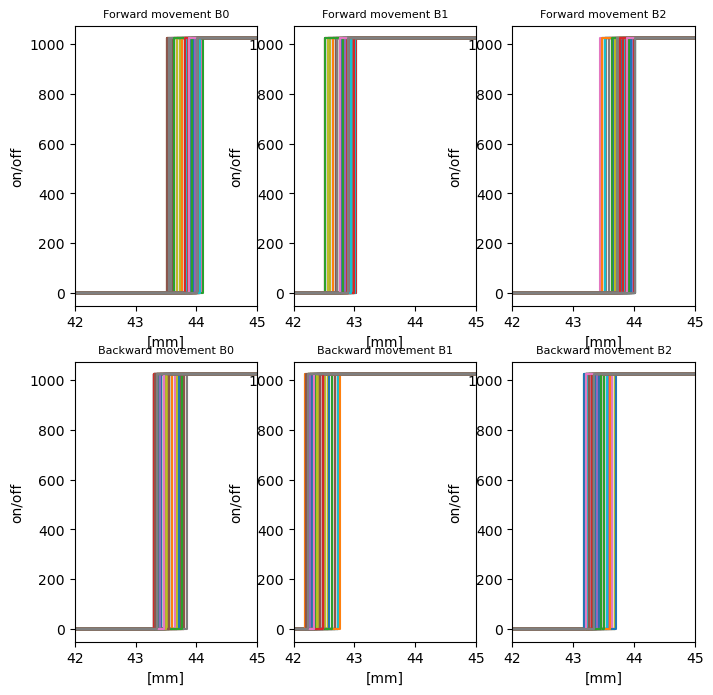

In [2]:
import matplotlib 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

fig, ax = plt.subplots(2,3, figsize=(8,8))

matplotlib.rc('axes', labelsize=SMALL_SIZE) 
matplotlib.rc('ytick', labelsize=SMALL_SIZE)
matplotlib.rc('ytick', labelsize=SMALL_SIZE)

 # [f0, f1, b0, b1, b2], [fw, bw, other]
for i in range(rounds-1):
    # alle fw rounds von b0
    ax[0,0].step([sublist[0] for sublist in stage_data[i]], [sublist[2] for sublist in arduino_data[i]])
    # alle bw rounds von b0 
    ax[1,0].step([sublist[1] for sublist in stage_data[i]], [sublist[2] for sublist in arduino_data[i]]) 
     # alle fw rounds von b1
    ax[0,1].step([sublist[0] for sublist in stage_data[i]], [sublist[3] for sublist in arduino_data[i]])
    # alle bw rounds von b1
    ax[1,1].step([sublist[1] for sublist in stage_data[i]], [sublist[3] for sublist in arduino_data[i]])     # alle fw rounds von b1
    # alle fw rounds von b2   
    ax[0,2].step([sublist[0] for sublist in stage_data[i]], [sublist[4] for sublist in arduino_data[i]])
    # alle bw rounds von b2
    ax[1,2].step([sublist[1] for sublist in stage_data[i]], [sublist[4] for sublist in arduino_data[i]])


ax[0,0].set_title('Forward movement B0', size=SMALL_SIZE)
ax[1,0].set_title('Backward movement B0', size=SMALL_SIZE)
ax[0,1].set_title('Forward movement B1', size=SMALL_SIZE)
ax[1,1].set_title('Backward movement B1', size=SMALL_SIZE)
ax[0,2].set_title('Forward movement B2', size=SMALL_SIZE)
ax[1,2].set_title('Backward movement B2', size=SMALL_SIZE)

for axis in ax.flat:
    axis.set(xlabel='[mm]', ylabel='on/off')
    #axis.set_xticks([35,37,39,41,43,45])
    axis.set_xlim([42,45])

plt.show() 

In [3]:
switch_pos_fw_b0 = []
switch_pos_fw_b1 = []
switch_pos_fw_b2 = []
switch_pos_fw_f0 = []
switch_pos_fw_f1 = []

switch_pos_bw_b0 = []
switch_pos_bw_b1 = []
switch_pos_bw_b2 = []
switch_pos_bw_f0 = []
switch_pos_bw_f1 = []

 # [f0, f1, b0, b1, b2], [fw, bw, other]
for i in range(rounds-1):

    # alle fw rounds von b0
    pos_fw_uncorrected = [sublist[0] for sublist in stage_data[i]]
    pos_bw_uncorrected = [sublist[1] for sublist in stage_data[i]]
    
    # correct position values by an offset
    pos_fw = []
    for x in pos_fw_uncorrected:
        if x is not None:  # Check if x is not None before subtracting
            pos_fw.append(x - 41.4)
        else:
            pos_fw.append(None)  # Or handle the case when x is None differently, if needed    
            
    pos_bw = []
    for x in pos_bw_uncorrected:
        if x is not None:  # Check if x is not None before subtracting
            pos_bw.append(x - 41.4)
        else:
            pos_bw.append(None)  # Or handle the case when x is None differently, if needed

    reed_f0 =  [sublist[0] for sublist in arduino_data[i]]
    reed_f1 =  [sublist[1] for sublist in arduino_data[i]]
    reed_b0 =  [sublist[2] for sublist in arduino_data[i]]
    reed_b1 =  [sublist[3] for sublist in arduino_data[i]]
    reed_b2 =  [sublist[4] for sublist in arduino_data[i]]
    
    # save the position where each sensor switches from off to on/on to off for each round i
    # each switch_pos_xx has len(rounds) and stores the value for each round when sensor switches
    for j in range(len(reed_b0)-1):
        if (reed_f0[j]==0) & (reed_f0[j+1]!=0):
            switch_pos_fw_f0.append((pos_fw[j]+pos_fw[j-1])/2)        
        if (reed_f1[j]==0) & (reed_f1[j+1]!=0):
            switch_pos_fw_f1.append((pos_fw[j]+pos_fw[j-1])/2)
        if (reed_b0[j]==0) & (reed_b0[j+1]!=0):
            switch_pos_fw_b0.append((pos_fw[j]+pos_fw[j-1])/2)       
        if (reed_b1[j]==0) & (reed_b1[j+1]!=0):
            switch_pos_fw_b1.append((pos_fw[j]+pos_fw[j-1])/2)        
        if (reed_b2[j]==0) & (reed_b2[j+1]!=0):
            switch_pos_fw_b2.append((pos_fw[j]+pos_fw[j-1])/2)          
            
        if (reed_f0[j]!=0) & (reed_f0[j+1]==0):
            switch_pos_bw_f0.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_f1[j]!=0) & (reed_f1[j+1]==0):
            switch_pos_bw_f1.append((pos_bw[j]+pos_bw[j-1])/2) 
        if (reed_b0[j]!=0) & (reed_b0[j+1]==0):
            switch_pos_bw_b0.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_b1[j]!=0) & (reed_b1[j+1]==0):
            switch_pos_bw_b1.append((pos_bw[j]+pos_bw[j-1])/2)          
        if (reed_b2[j]!=0) & (reed_b2[j+1]==0):
            switch_pos_bw_b2.append((pos_bw[j]+pos_bw[j-1])/2)  



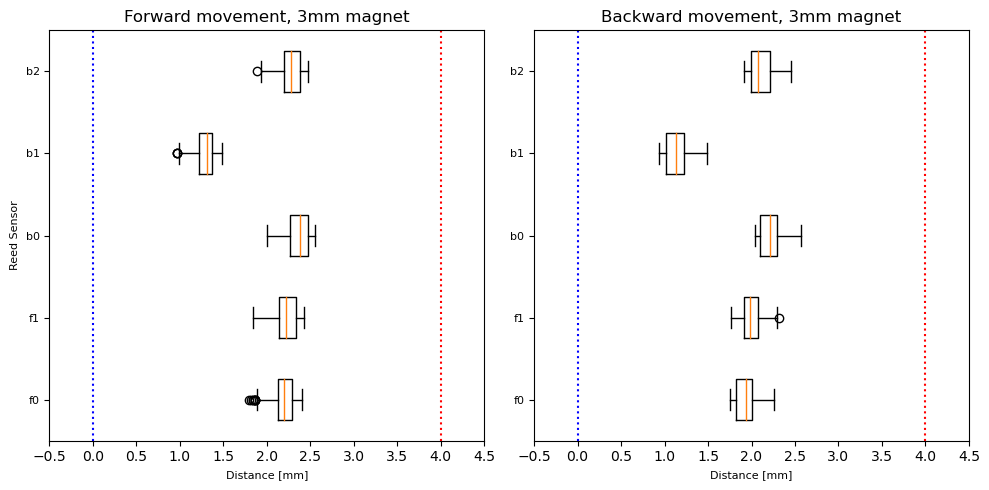

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# prepare data for boxplot
x_fw = [switch_pos_fw_f0, switch_pos_fw_f1, switch_pos_fw_b0, switch_pos_fw_b1, switch_pos_fw_b2]
x_bw = [switch_pos_bw_f0, switch_pos_bw_f1, switch_pos_bw_b0, switch_pos_bw_b1, switch_pos_bw_b2]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the first boxplot on the first subplot
axes[0].boxplot(x_fw, vert=False)
axes[1].boxplot(x_bw, vert=False)

axes[0].set_xlabel('Distance [mm]')
axes[0].set_ylabel('Reed Sensor')
axes[0].set_title('Forward movement, 3mm magnet')
axes[1].set_title('Backward movement, 3mm magnet')

for axis in axes.flat:
    axis.set_xlabel('Distance [mm]')
    axis.set_yticks([1,2,3,4,5],['f0', 'f1', 'b0', 'b1', 'b2'])
    axis.set_xticks([-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5])
    axis.axvline(x=0, color = 'b', ls=':')
    axis.axvline(x=4, color = 'r', ls=':')


plt.tight_layout()
plt.show()


Plot the reed step functions in to one plot, normalize x and y data, include verticals for touch/pressure boundary

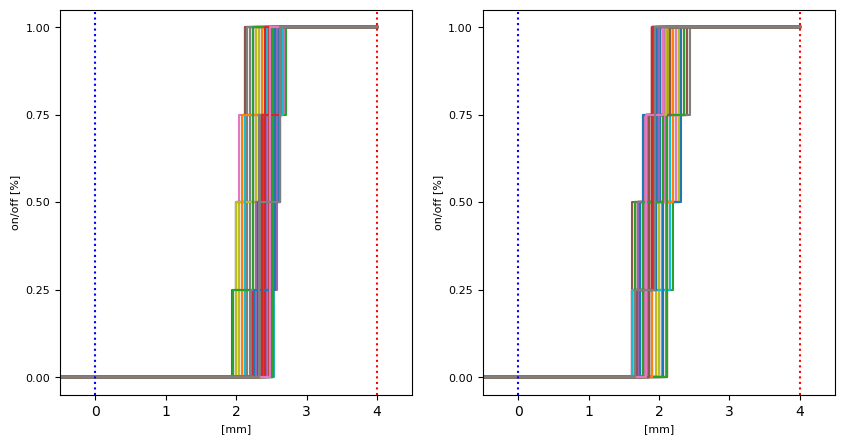

In [33]:
sum_reed = []
pos_fw_all = []
pos_bw_all = []

fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(rounds-1):
    pos_fw = []
    pos_bw = []

    # save subarrays
    pos_fw_uncorrected = [sublist[0] for sublist in stage_data[i]]
    pos_bw_uncorrected = [sublist[1] for sublist in stage_data[i]]
          
    reed_f0 =  [sublist[0] for sublist in arduino_data[i]]
    reed_f1 =  [sublist[1] for sublist in arduino_data[i]]
    reed_b0 =  [sublist[2] for sublist in arduino_data[i]]
    reed_b2 =  [sublist[4] for sublist in arduino_data[i]]
    
    # hier den kompletten Array addieren (i ist die runde, nicht die stelle in der runde)
    sum_reed.append([round((reed_f0[j] + reed_f1[j] + reed_b0[j] + reed_b2[j])/4092,2) for j in range(len(reed_f0))])

    # correct the values with an offset (touch but no pressure to probe is 0)
    for x in pos_fw_uncorrected:
        if x is not None:  # Check if x is not None before substracting
            pos_fw.append(x - 41.4)
        else:
            pos_fw.append(None)  # Or handle the case when x is None differently, if needed     
            
    for x in pos_bw_uncorrected:
        if x is not None:  # Check if x is not None before subtracting
            pos_bw.append(x - 41.4)
        else:
            pos_bw.append(None)  # Or handle the case when x is None differently, if needed 
    
    pos_fw_all.append(pos_fw)
    pos_bw_all.append(pos_bw)

 

    ax[0].step(pos_fw_all[i],sum_reed[i])
    ax[1].step(pos_bw_all[i],sum_reed[i])
    i=i+1


for axis in ax.flat:
    axis.set(xlabel='[mm]', ylabel='on/off [%]')
    axis.set_xlim(-0.5,4.5)
    axis.set_yticks([0,0.25,0.5,0.75,1])
    axis.axvline(x=0, color = 'b', ls=':')
    axis.axvline(x=4, color = 'r', ls=':')






save only values for position that are not None

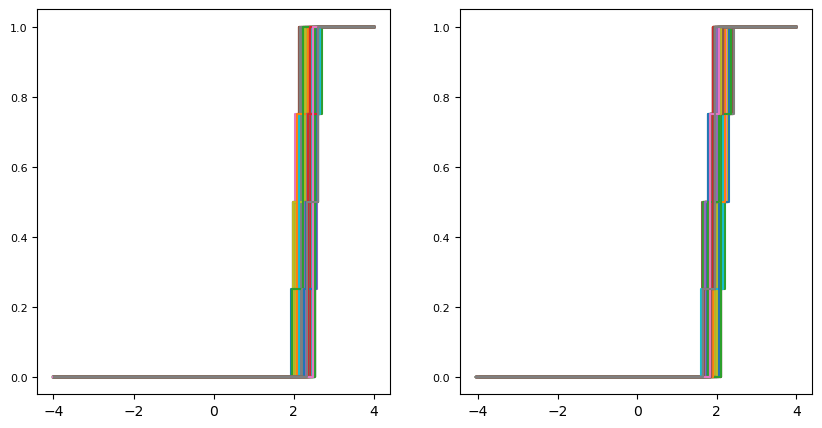

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

pos_fw_noNone = []
pos_bw_noNone = []
sum_reed_fw = []
sum_reed_bw = []

for i in range(rounds-1):
    pos_fw_noNone_i = []
    pos_bw_noNone_i = []
    sum_reed_fw_noNone_i = []
    sum_reed_bw_noNone_i = []

    pos_fw_round_i = pos_fw_all[i]
    pos_bw_round_i = pos_bw_all[i]
    sum_reed_i = sum_reed[i]

    # die Daten von None Werten bereinigen 
    for j in range(len(pos_fw_round_i)):
        if pos_fw_round_i[j] != None:
            pos_fw_noNone_i.append(pos_fw_round_i[j])
            sum_reed_fw_noNone_i.append(sum_reed_i[j])        
            
        if pos_bw_round_i[j] != None:
            pos_bw_noNone_i.append(pos_bw_round_i[j])
            sum_reed_bw_noNone_i.append(sum_reed_i[j])

    sum_reed_fw.append(sum_reed_fw_noNone_i)
    sum_reed_bw.append(sum_reed_bw_noNone_i)
    pos_fw_noNone.append(pos_fw_noNone_i)    
    pos_bw_noNone.append(pos_bw_noNone_i) 

    # gleicher plot wie oben! Sehr gut
    ax[0].step(pos_fw_noNone[i],sum_reed_fw[i])
    ax[1].step(pos_bw_noNone[i],sum_reed_bw[i])    


Does the same thing as the code above just more compact but also less understandable.

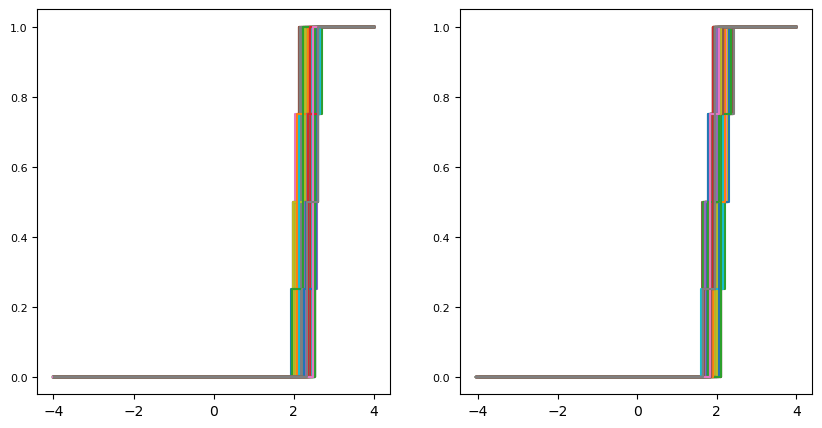

In [34]:
pos_fw_noNone = [ [pos_fw_all[i][j] for j in range(len(pos_fw_all[i])) if pos_fw_all[i][j] is not None] for i in range(rounds-1)]
pos_bw_noNone = [ [pos_bw_all[i][j] for j in range(len(pos_bw_all[i])) if pos_bw_all[i][j] is not None] for i in range(rounds-1)]

sum_reed_fw = [ [sum_reed[i][j] for j in range(len(pos_fw_all[i])) if pos_fw_all[i][j] is not None] for i in range(rounds-1)]
sum_reed_bw = [ [sum_reed[i][j] for j in range(len(pos_bw_all[i])) if pos_bw_all[i][j] is not None] for i in range(rounds-1)]

fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(rounds-1):
    ax[0].step(pos_fw_noNone[i],sum_reed_fw[i])
    ax[1].step(pos_bw_noNone[i],sum_reed_bw[i])  


work with pos_fw_noNone, pos_bw_noNone, sum_reed_fw and sum_reed_bw

In [116]:
def make_plot_stuff():
    for axis in ax.flat:
        axis.set(xlabel='[mm]', ylabel='on/off [%]')
        axis.set_xlim(-0.5,4.5)
        axis.set_yticks([0,0.25,0.5,0.75,1])
        axis.axvline(x=0, color = 'b', ls=':')
        axis.axvline(x=4, color = 'r', ls=':')

def find_fw_boundaries(pos_f, reed_f, reed_025_f, reed_05_f, reed_075_f, reed_10_f):
    for j in range(len(pos_f)-1):
        if (reed_f[j+1] == 0.25) & (reed_f[j+1] != reed_f[j]):
            reed_025_f.append(pos_f[j+1])  

        if (reed_f[j+1] == 0.5) & (reed_f[j+1] != reed_f[j]):
            reed_05_f.append(pos_f[j+1])      

        if (reed_f[j+1] == 0.75) & (reed_f[j+1] != reed_f[j]):
            reed_075_f.append(pos_f[j+1])    
            
        if (reed_f[j+1] == 1.0) & (reed_f[j+1] != reed_f[j]):
            reed_10_f.append(pos_f[j+1])
            
            
def find_bw_boundaries(pos_b, reed_b, reed_025_b, reed_05_b, reed_075_b, reed_10_b):
    # turn around arrays to use same logic as above
    pos_b = pos_b[::-1]
    reed_b = reed_b[::-1]

    for j in range(len(pos_b)-1):
        if (reed_b[j+1] == 0.25) & (reed_b[j+1] != reed_b[j]):
            reed_025_b.append(pos_b[j+1])  

        if (reed_b[j+1] == 0.5) & (reed_b[j+1] != reed_b[j]):
            reed_05_b.append(pos_b[j+1])      

        if (reed_b[j+1] == 0.75) & (reed_b[j+1] != reed_b[j]):
            reed_075_b.append(pos_b[j+1])    
            
        if (reed_b[j+1] == 1.0) & (reed_b[j+1] != reed_b[j]):
            reed_10_b.append(pos_b[j+1])



[0, 2.4084114805852375, 2.5171388566997246, 2.5815486492060353, 2.7583407453625797, 5]
[0, 1.6888604708888892, 1.7918685684625915, 1.8892707899895682, 2.086864085026253, 5]


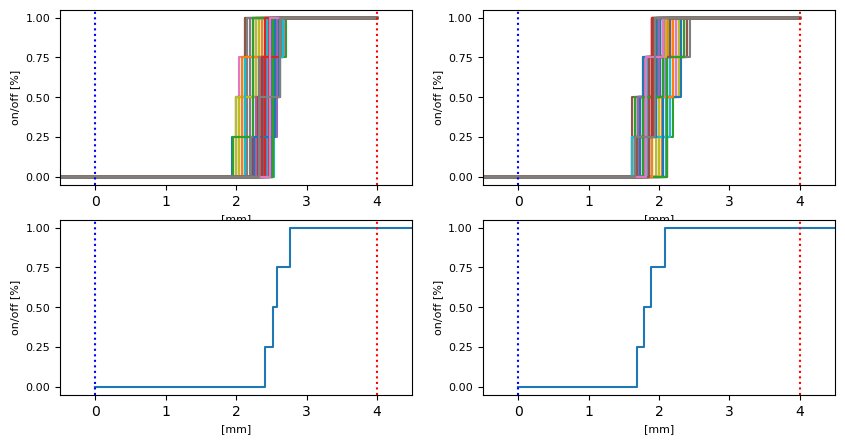

In [117]:
reed_025_f = []
reed_05_f = []
reed_075_f = []
reed_10_f = []

reed_025_b = []
reed_05_b = []
reed_075_b = []
reed_10_b = []

mean_reed_fw = [0]
mean_reed_bw = [0]

y_val = [0,0.25,0.5,0.75,1.0,1.0]

for i in range(rounds-1):
    reed_f = sum_reed_fw[i]
    reed_b = sum_reed_bw[i]
    pos_f = pos_fw_noNone[i]
    pos_b = pos_bw_noNone[i]    

    #print(any(x not in [0,0.25,0.5,0.75,1] for x in reed))

    find_fw_boundaries(pos_f, reed_f, reed_025_f, reed_05_f, reed_075_f, reed_10_f)
    find_bw_boundaries(pos_b, reed_b, reed_025_b, reed_05_b, reed_075_b, reed_10_b)

mean_reed_fw.append(np.mean(reed_025_f))
mean_reed_fw.append(np.mean(reed_05_f))
mean_reed_fw.append(np.mean(reed_075_f))
mean_reed_fw.append(np.mean(reed_10_f))
# for the sake of continuity
mean_reed_fw.append(5)

mean_reed_bw.append(np.mean(reed_025_b))
mean_reed_bw.append(np.mean(reed_05_b))
mean_reed_bw.append(np.mean(reed_075_b))
mean_reed_bw.append(np.mean(reed_10_b))
# for the sake of continuity
mean_reed_bw.append(5)

print(mean_reed_fw)
print(mean_reed_bw)

fig, ax = plt.subplots(2,2, figsize=(10,5))

for i in range(rounds-1):
    ax[0,0].step(pos_fw_noNone[i],sum_reed_fw[i])
    ax[0,1].step(pos_bw_noNone[i],sum_reed_bw[i]) 

ax[1,0].step(mean_reed_fw,y_val, where='post')
ax[1,1].step(mean_reed_bw,y_val, where='post')

make_plot_stuff()

# wie mache ich die Perzentile? 
# das bekomme ich auch noch hin!! 
